# Solving the stochastic/rough Poisson equation

We aim to solve the Poisson equation in 1-D
$$
-\Delta u = f \quad \text{in} \quad(0, L) \\
u(x) = 0 \quad \text{for} \quad x = 0, L
$$

We will choose $u$ of the form:
$$
u = \sum_{n=1}^\infty a_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

The functions 
$$
 \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$
form an orthonrmal basis of $L^2(0, L)$. Moreover 
$$
-\Delta  \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) =  \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = \lambda_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

In this way we have that 
$$
-\Delta u =  \sum_{n=1}^\infty a_n \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = f
$$
We will select the coefficients 
$$
a_n = \frac{\xi_n}{n^{\frac{\alpha}{2}}}  \quad \xi_n \sim \mathcal{N}(0,1) \; \text{i.i.d.}
$$
so that 
$$
||u||^2_{H^s} = \sum_{n=1}\frac{\xi^2_n}{n^{\alpha}}\lambda_n^s \propto \sum_{n=1}\frac{\xi^2_n}{n^{\alpha}}n^{2s} = \sum_{n=1}\frac{\xi^2_n}{n^{\alpha-2s}} 
$$
Therefore $u \in H^{s}$ for any $s < \frac{\alpha -1}{2}$ and so $f \in H^{s-2}$. We therefore select $2s +1 + 0.25= \alpha$

In [316]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_18436\1496758469.py:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [317]:
import utils_rough_pde
from utils_rough_pde import *

In [318]:
def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        #print(c)
        values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values

In [334]:
# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 1
alpha = 2*s+1 + 0.25
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2

x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L)

3.25


Text(0.5, 1.0, 'Squared coefficients of f')

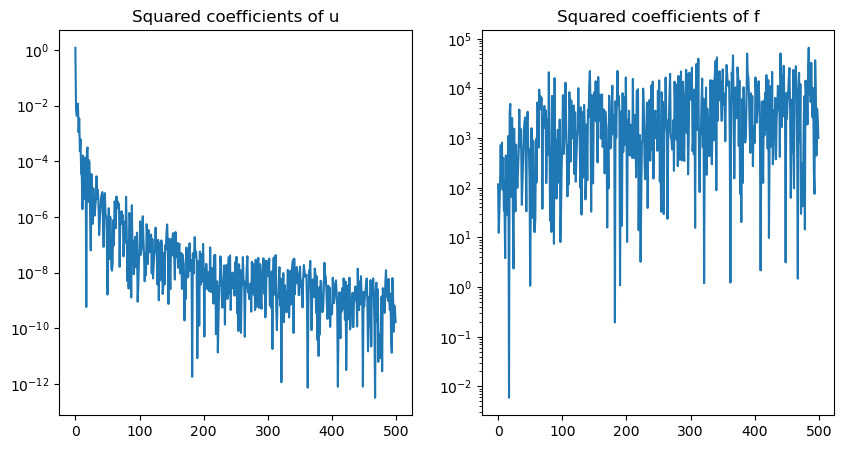

In [335]:
# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')



In [336]:
# values = 0
# for i, c in enumerate(coef_u):
#         values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
#         plt.plot(x, values)

Text(0.5, 1.0, 'Function f')

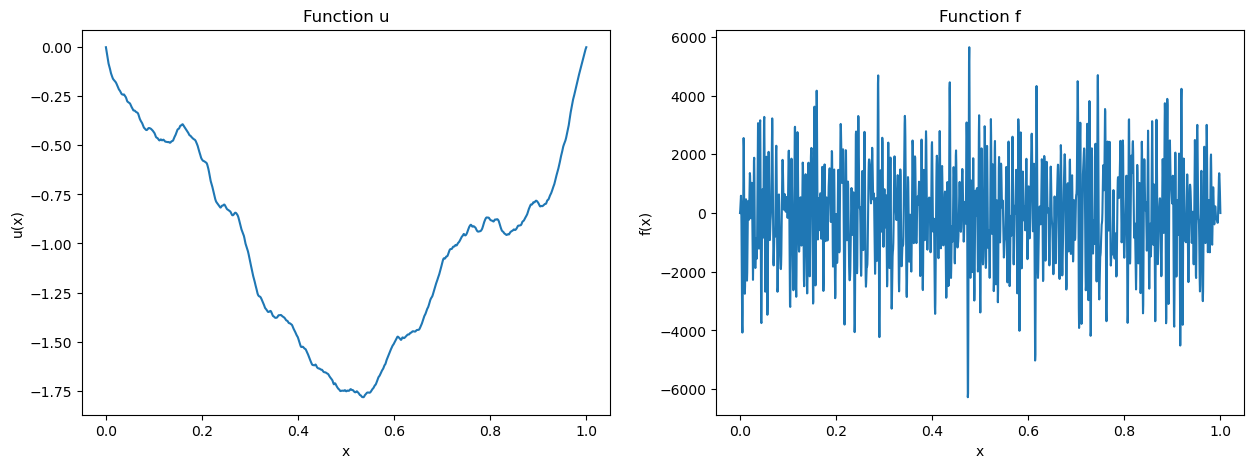

In [337]:
# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")


# Defining our weak measurements

In [338]:
epsilon_values =  jnp.array([0.01])

# Boundary of the domain
lower, upper = 0.0, 1.0

loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

print("Number of test functions: ", N_test_functions)

Number of test functions:  50


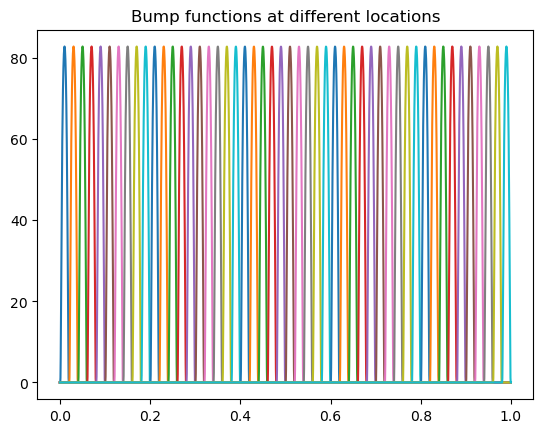

In [339]:
bump_values = vmap_bump(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

In [340]:
from scipy.special import roots_legendre
n_order = 35
x_q, w_q = roots_legendre(n_order)
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

# Construct the mmatrix of weighted bump functions 
psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

psi_matrix

Array([[2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97],
       [2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97],
       [2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97],
       ...,
       [2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97],
       [2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97],
       [2.14430662e-97, 2.39494478e-20, 1.68220298e-09, ...,
        1.68220298e-09, 2.39494478e-20, 2.14430662e-97]], dtype=float64)

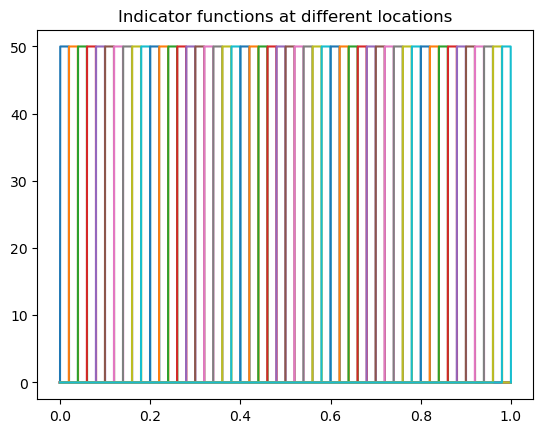

In [341]:
indicator_values = vmap_indicator(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, indicator_values[:, 0, i])
plt.title("Indicator functions at different locations")
plt.show()

In [342]:
from scipy.special import roots_legendre
n_order = 50
x_q, w_q = roots_legendre(n_order)
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

# Construct the mmatrix of weighted bump functions 
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi
psi_matrix

Array([[0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431],
       [0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431],
       [0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431],
       ...,
       [0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431],
       [0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431],
       [0.00145431, 0.0033799 , 0.00529527, ..., 0.00529527, 0.0033799 ,
        0.00145431]], dtype=float64)

# Plotting the kernel

In [343]:
center = jnp.array([0.5])
length_scale = 0.1

Text(0.5, 1.0, 'Kernel function')

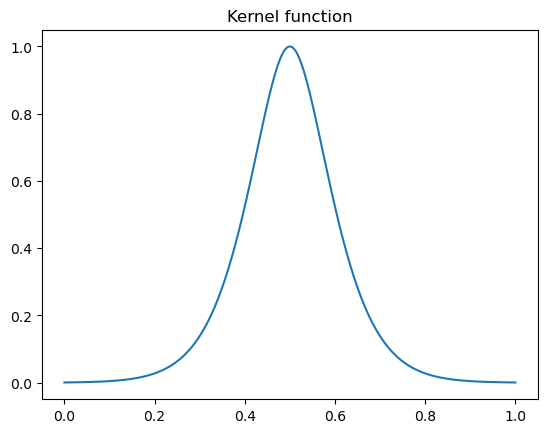

In [344]:
kernel_values = vmap_kernel(x, center, length_scale)
plt.plot(x, kernel_values)
plt.title("Kernel function")

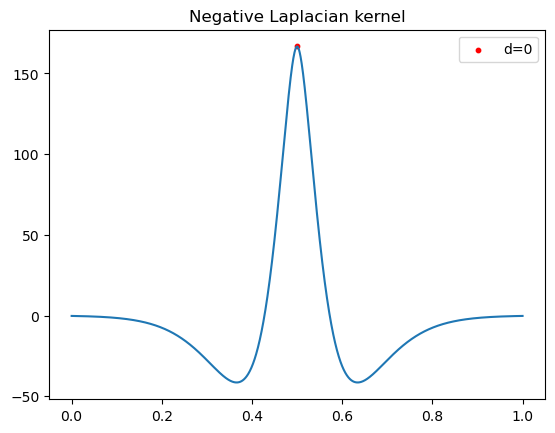

In [345]:
neg_laplacian_values = vmap_kernel_laplacian(x, center, length_scale)
plt.plot(x, neg_laplacian_values)
plt.scatter(center,  vmap_kernel_laplacian(center, center, length_scale), color = "red", label = "d=0", s= 10)
plt.title("Negative Laplacian kernel")
plt.legend()
plt.show()

In [346]:
center, vmap_kernel_laplacian(center, center, length_scale)

(Array([0.5], dtype=float64), Array([[166.66666667]], dtype=float64))

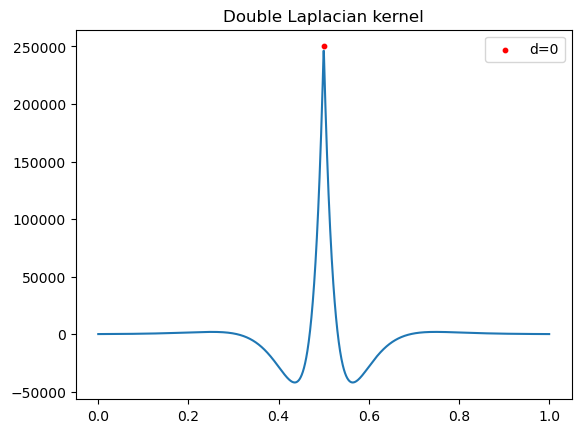

In [347]:
double_laplacian_values = vmap_kernel_double_laplacian(x, center, length_scale)
plt.plot(x, double_laplacian_values)
plt.scatter(center,  vmap_kernel_double_laplacian(center, center, length_scale), color = "red", label = "d=0", s= 10)
plt.title("Double Laplacian kernel")
plt.legend()
plt.show()

In [348]:
double_laplacian_values[490:510]

Array([[1949.15078004],
       [1950.91490324],
       [1952.54349184],
       [1954.03407672],
       [1955.38415938],
       [1956.59121173],
       [1957.65267581],
       [1958.56596356],
       [1959.32845657],
       [1959.93750582],
       [1960.39043144],
       [1960.68452246],
       [1960.81703656],
       [1960.7851998 ],
       [1960.5862064 ],
       [1960.21721847],
       [1959.67536575],
       [1958.95774537],
       [1958.06142161],
       [1956.9834256 ]], dtype=float64)

# Solving the Poisson equation

To solve the Poisson equation, we solve the following linear system
$$
\Theta \bold{c} = Y
$$
where 
$$
Y = \begin{bmatrix}
\bold{0} \\
[f, \psi]
\end{bmatrix}
$$
and
$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) &  -\Delta_y K(X_{\partial\Omega}, \boldsymbol{\psi}) \\
-\Delta_y K( X_{\partial\Omega}, \boldsymbol{\psi})^\intercal & \Delta_x\Delta_y K( \boldsymbol{\psi}, \boldsymbol{\psi})
\end{bmatrix}
$$

The resulting function is given by 
$$
\begin{pmatrix}
K(\cdot \;,  X_{\partial\Omega}),  -\Delta_y K(\cdot \;, \boldsymbol{\psi})
\end{pmatrix}\bold{c}
$$

# Observing the convergence rates

In [350]:
n_meas_list = jnp.arange(200, 300, 10, dtype=int)
# Boundary of the domain
lower, upper = 0.0, 1.0
length_scale = 0.1
boundary = jnp.array([[lower, upper]]).T

nugget_interior = 5e-7
nugget_boundary = 1e-12

In [351]:
measurement_type = "indicator"

In [352]:
error_list = []
relative_error_list = []

pred_list = []
for n_meas in n_meas_list:

    # Construct the measurements
    epsilon_values =  jnp.array([1/(n_meas*2)])
    loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
    support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
    vol = support[:,1] - support[:,0]
    N_test_functions = loc_values.shape[0]

    print("Number of test functions: ", N_test_functions)


    root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

    # Construct the mmatrix of weighted measurement functions 
    if measurement_type == "indicator":
        psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
    elif measurement_type == "bump":
        psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
    else:
        # Raise an error
        print("Measurement type not recognized")
        break

    psi_matrix = psi_matrix * w_psi

    # Compute the RHS of the linear system
    f_quad = evaluate_function(root_psi, coef_f, L)
    f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_meas])

    # Compute the kernel matrix
    print("Constructing the kernel matrix")
    theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = N_test_functions)])

    # Solve the linear system
    print("Solving the linear system")
    c = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), Y, assume_a='pos')

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary)
    pred_list.append(pred)

    # Compute the error between the true solution and the numerical solution
    loss, relative_loss = compute_error(pred, u_values)
    error_list.append(loss)
    relative_error_list.append(relative_loss)




error_list = jnp.array(error_list)
relative_error_list = jnp.array(relative_error_list)

pred_list = jnp.array(pred_list)


Number of test functions:  500
Constructing the kernel matrix


In [ ]:
print("Best error: ", jnp.min(error_list))
print("Best relative error: ", jnp.min(relative_error_list))

Best error:  0.023453927100914203
Best relative error:  0.02113044687451224


Text(0.5, 1.0, 'Relative $L^2$ Error')

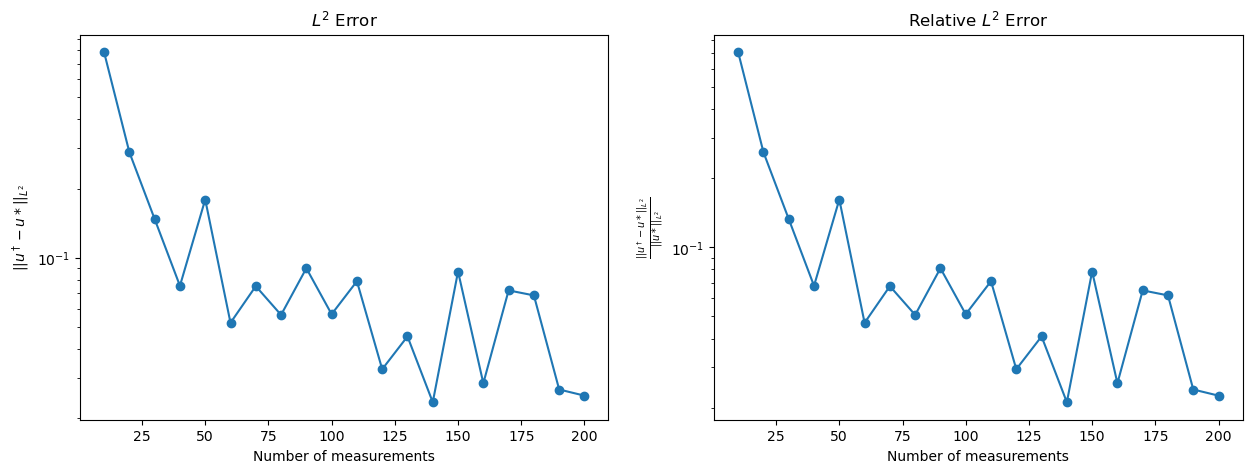

In [ ]:
# Plot both the error and the relative error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(n_meas_list, error_list)
ax[0].scatter(n_meas_list, error_list)
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of measurements")
ax[0].set_ylabel(r"$||u^\dagger - u* ||_{L^2}$")
ax[0].set_title(r"$L^2$ Error")

ax[1].plot(n_meas_list, relative_error_list)
ax[1].scatter(n_meas_list, relative_error_list)
ax[1].set_yscale("log")
ax[1].set_xlabel("Number of measurements")
ax[1].set_ylabel(r"$\frac{||u^\dagger - u* ||_{L^2}}{|| u* ||_{L^2}}$")
ax[1].set_title(r"Relative $L^2$ Error")


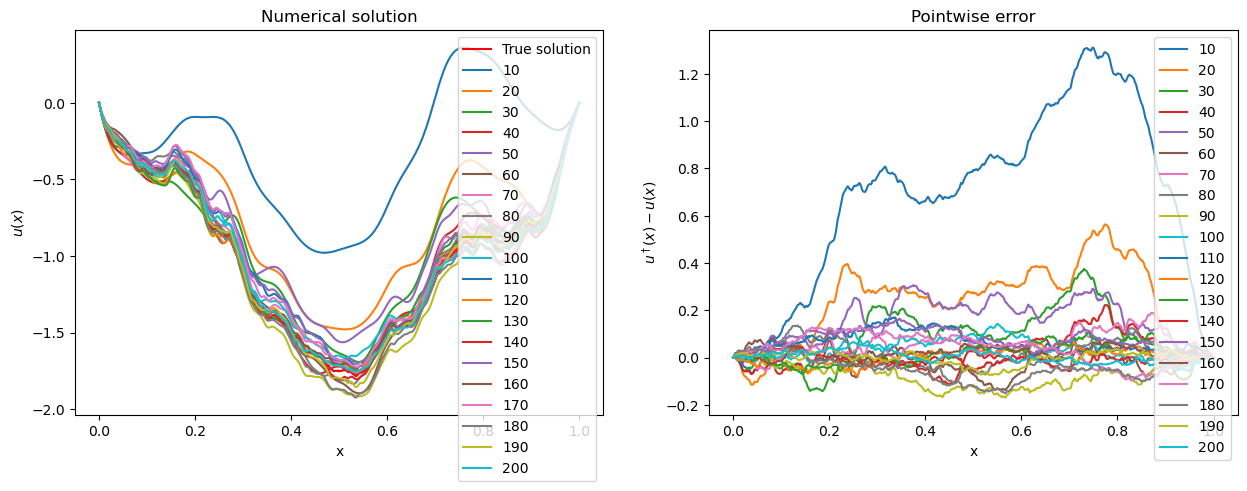

In [ ]:
# For each prediction, plot the true solution and the numerical solution and the error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values, label = "True solution", color = "Red")
for i, pred in enumerate(pred_list):
    ax[0].plot(x, pred, label = "{}".format(n_meas_list[i]))
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(r"$u(x)$")
    ax[0].set_title("Numerical solution")

    ax[1].plot(x, pred - u_values, label = "{}".format(n_meas_list[i]))
    ax[1].set_xlabel("x")
    ax[1].set_ylabel(r"$u^\dagger(x) - u(x)$")
    ax[1].set_title("Pointwise error")


ax[0].legend()
ax[1].legend()

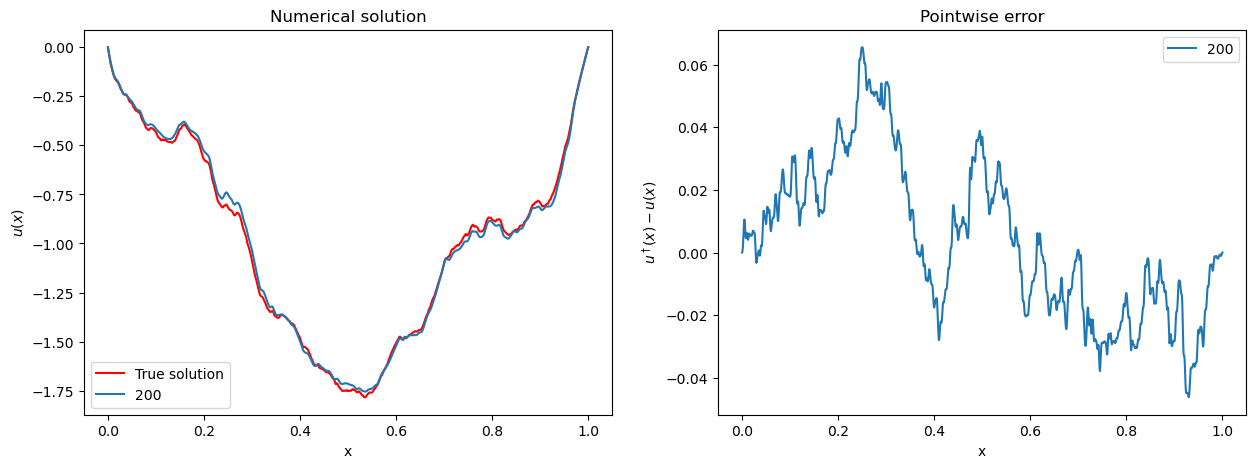

In [ ]:
# For each prediction, plot the true solution and the numerical solution and the error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values, label = "True solution", color = "Red")
for i, pred in enumerate(pred_list[-1:]):
    ax[0].plot(x, pred, label = "{}".format(n_meas_list[-1]))
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(r"$u(x)$")
    ax[0].set_title("Numerical solution")

    ax[1].plot(x, pred - u_values, label = "{}".format(n_meas_list[-1]))
    ax[1].set_xlabel("x")
    ax[1].set_ylabel(r"$u^\dagger(x) - u(x)$")
    ax[1].set_title("Pointwise error")


ax[0].legend()
ax[1].legend()

# Grid search over the best hyper-paramerers

In [26]:
lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T

nugget_interior = 1e-7
nugget_boundary = 1e-12

length_scale_list = jnp.linspace(0.01, 0.5, 25)

length_scale_list

Array([0.01      , 0.03041667, 0.05083333, 0.07125   , 0.09166667,
       0.11208333, 0.1325    , 0.15291667, 0.17333333, 0.19375   ,
       0.21416667, 0.23458333, 0.255     , 0.27541667, 0.29583333,
       0.31625   , 0.33666667, 0.35708333, 0.3775    , 0.39791667,
       0.41833333, 0.43875   , 0.45916667, 0.47958333, 0.5       ],      dtype=float64)

In [27]:
error_list = []
relative_error_list = []

pred_list = []

n_meas = 300
for length_scale in length_scale_list:

    # Construct the measurements
    epsilon_values =  jnp.array([1/(n_meas*2)])
    loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
    support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
    vol = support[:,1] - support[:,0]
    N_test_functions = loc_values.shape[0]

    print("Number of test functions: ", N_test_functions)


    root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

    # Construct the mmatrix of weighted measurement functions 
    if measurement_type == "indicator":
        psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
    elif measurement_type == "bump":
        psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)

    psi_matrix = psi_matrix * w_psi

    # Compute the RHS of the linear system
    f_quad = evaluate_function(root_psi, coef_f, L)
    f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_meas])

    # Compute the kernel matrix
    print("Constructing the kernel matrix with length scale {}".format(length_scale))
    theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = N_test_functions)])

    # Solve the linear system
    print("Solving the linear system")
    c = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), Y, assume_a='pos')

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary)
    pred_list.append(pred)

    # Compute the error between the true solution and the numerical solution
    loss, relative_loss = compute_error(pred, u_values)
    error_list.append(loss)
    relative_error_list.append(relative_loss)




error_list = jnp.array(error_list)
relative_error_list = jnp.array(relative_error_list)

pred_list = jnp.array(pred_list)


Number of test functions:  300
Constructing the kernel matrix with length scale 0.01
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.030416666666666665
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.05083333333333333
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.07125
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.09166666666666666
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.11208333333333333
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.1325
Solving the linear system
Number of test functions:  300
Constructing the kernel matrix with length scale 0.15291666666666665
Solving the linear system
Number of test functions:  300


In [28]:
print("Best error: ", jnp.min(error_list))
print("Best relative error: ", jnp.min(relative_error_list))

Best error:  0.001998056350088391
Best relative error:  0.0018004186516549607


In [29]:
length_scale_list[jnp.argmin(error_list)]


Array(0.11208333, dtype=float64)

Text(0.5, 1.0, 'Relative error')

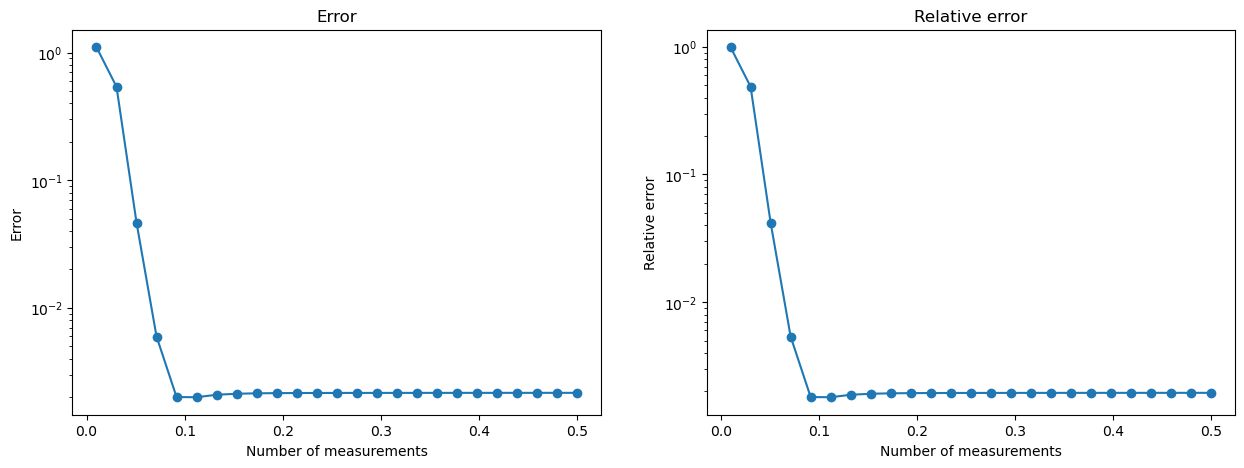

In [30]:
# Plot both the error and the relative error
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(length_scale_list, error_list)
ax[0].scatter(length_scale_list, error_list)
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of measurements")
ax[0].set_ylabel("Error")
ax[0].set_title("Error")

ax[1].plot(length_scale_list, relative_error_list)
ax[1].scatter(length_scale_list, relative_error_list)
ax[1].set_yscale("log")
ax[1].set_xlabel("Number of measurements")
ax[1].set_ylabel("Relative error")
ax[1].set_title("Relative error")


In [85]:
[1.5**i for i in range(5, 20)]

[7.59375,
 11.390625,
 17.0859375,
 25.62890625,
 38.443359375,
 57.6650390625,
 86.49755859375,
 129.746337890625,
 194.6195068359375,
 291.92926025390625,
 437.8938903808594,
 656.8408355712891,
 985.2612533569336,
 1477.8918800354004,
 2216.8378200531006]

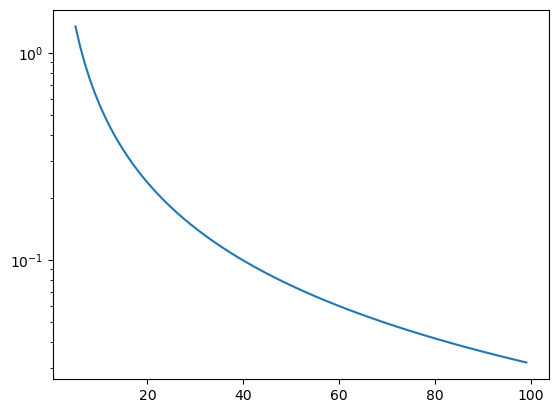

In [28]:
l = 1.25
increments = jnp.arange(5, 100)
error_list = increments**(-l)*10
plt.plot(increments, error_list)
plt.yscale("log")

In [53]:
log_increment = jnp.log(increments)
log_error = jnp.log(error_list)

a = jnp.hstack([log_increment.reshape(-1, 1), jnp.ones_like(log_increment.reshape(-1, 1))])
b = log_error
print(a.shape, b.shape)
r, C = jnp.linalg.lstsq(a, b)[0]
r, C = -r.item(), jnp.exp(C).item()

r, C

(95, 2) (95,)


(1.25, 10.00000000000001)

# Computing $H^s$ norms via the FFT

In [55]:
from jax.numpy.fft import fft

In [175]:
# def compute_coeff(f_values):
#     f_hat = fft(f_values)
#     coeff = []
#     N = int(len(f_hat)/2)
#     for i in range(N):
#         if i == 0:
#             coeff.append([jnp.real(f_hat[i])/2, jnp.real(f_hat[i])/2])
#         else:
#             # Extract the coefficients corresponding to the sine basis
#             coeff.append([2*jnp.real(f_hat[i]), -2*jnp.imag(f_hat[i]) ])
#     return jnp.array(coeff)


# #     return values

# def evaluate_basis(coeff, domain):
#     coeff = coeff[None]
#     cos_basis = jnp.array([jnp.cos(2*jnp.pi*k/L*domain) for k in range(1, coeff.shape[1])])
#     sin_basis = jnp.array([jnp.sin(2*jnp.pi*k/L*domain) for k in range(1, coeff.shape[1])])
#     #constant_basis = np.ones(domain.shape)[:, None]

#     print(coeff.shape)

#     return jnp.squeeze(coeff[:,0,0][:, None] + coeff[:,0,1][:, None] + (coeff[:,1:,0]@cos_basis) + (coeff[:,1:,1]@sin_basis))

# coef_u_fft = compute_coeff(u_values)
# u_values_fft = evaluate_basis(coef_u_fft, x)

# plt.plot(x, u_values_fft/999)
# plt.plot(x, u_values)

# Computing the $H^s$ norms via trapeizodal rule

In [305]:
def compute_projection_sin(x, f_values, n_coef):
    # Compute the projection of the function f on the sine basis
    # f_values: values of the function f on the domain x
    # n_coef: number of coefficients to compute
    # return: the coefficients of the projection
    
    sin_basis = jnp.sqrt(2/L)*jnp.array([jnp.sin(jnp.pi*k/L*x) for k in range(1, n_coef+1)])

    return jnp.mean(f_values[None]*sin_basis, axis = -1)

def compute_h_norm(coef, s):
    eigenvalues = jnp.arange(1, coef.shape[0]+1)**2*jnp.pi**2/L**2
    return jnp.sqrt(jnp.sum(coef**2*eigenvalues**s))

def compute_error_h(pred, true_coef, s):

    # Compute the preojection of the prediction on the sine basis
    compute_projection_sin(x, pred, n_coef = true_coef.shape[0])
    # Compute the error between the true coefficients and the predicted coefficients
    error = compute_h_norm(true_coef - pred, s)
    norm_true = compute_h_norm(true_coef, s)

    return error, error/norm_true


In [313]:
coef_u.shape

(500,)

In [306]:
u_proj = compute_projection_sin(x, u_values, n_coef)
u_recon = evaluate_function(x, u_proj, L=L)

In [307]:
final_pred = pred_list[-1]
pred_proj = compute_projection_sin(x, final_pred, n_coef)
pred_recon = evaluate_function(x, pred_proj, L=L)

In [315]:
pointwise_error_proj =  compute_projection_sin(x, final_pred - u_values, n_coef)
pointwise_error_recon = evaluate_function(x, pointwise_error_proj, L=L)

plt.plot(x, u_recon)

In [308]:
compute_error(final_pred, u_values)

(Array(0.02505202, dtype=float64), Array(0.02257022, dtype=float64))

In [311]:
compute_h_norm(coef_u - pred_proj, s=1)

Array(1.76768539, dtype=float64)

# Computing the $H^1$ norm via autograd

(500,)

# Solving the stochastic heat equation

The stochastic heat equation is given by 
$$
\frac{d u}{d t} = \Delta u + \frac{dW}{dt}
$$

Solving the heat equation with the Cranck-Nicolson time stepping involves the following.

1. At $n=0$

$$ 
u_{0}(x) = g(x)
$$

2. At each $n+1$, solve the following 

$$
u_{n+1} - \Delta t\frac{1}{2} \Delta u_{n+1} = u_{n} + \Delta t\frac{1}{2} \Delta u_{n} + dW_n \\
(I - \frac{\Delta t}{2} \Delta) u_{n+1} =  u_{n} + \Delta t\frac{1}{2} \Delta u_{n} + dW_n
$$

Hence at each timestep we need to be able 
* Compute $\Delta u_n$
* Solve $(I - \frac{\Delta t}{2} \Delta) u_{n+1} = h_n $